<a href="https://colab.research.google.com/github/martinsphl/MAI5035/blob/main/TAREFA_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAI5035: Task 1.2 by Paulo Martins, Vitória Barbosa and Isaac Saito

## Problem Definition

The foreign exchange market is a complex, volatile and high-risk system. Independent individuals and companies follow the price of the US dollar to decide on buying/selling of various kinds, such as import contracts, electronics purchases, financial market shares, etc.

**Purpose of the Analysis**

The aim of this analysis is to predict the future price of the dollar for the next day. In this sense, we will offer categories as a target column that represent the future variation of the dollar.

As this is a classification problem, we will use KNN and Logistic Regression to predict the categories.


## Importing Main Libraries

In [114]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

# Preprocess data: normalization and ordinal enconder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# For Classification Task
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Avoiding warning messages
import warnings
warnings.filterwarnings('ignore')

# Setting a global seed
np.random.seed(7)

## Data Gathering

We created a github public repository to upload the csv dataset and do software versioning. From github public url, we load the data into a pandas dataframe.

**Data Description:**

US Dollar Index dataset ([Available Here](https://www.kaggle.com/datasets/balabaskar/us-dollar-index-data))

1.   Date: Date of observation (time variable in the format Month DD, YYYY)
2.   Price: Dollar index at market close (continuous and positive variable)
3.   Open: Dollar index at market opening (continuous and positive variable)
4.  High: Highest index value observed on the day (continuous, positive variable)
5. Low: Lowest index value observed on the day (continuous, positive variable)
6. Change %: Change in the dollar index compared to the previous day (continuous variable in percent)

In [115]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/US%20Dollar%20Index%20Historical%20Data.csv'

# Creating pandas dataframe from each dataset
df_dollar = pd.read_csv(dataset_url, names=['date', 'last_price', 'first_price', 'biggest_price', 'lowest_price', 'perc_variation'], skiprows=1, delimiter=',')

# Remove '%'symbol from pec_variation column
df_dollar['perc_variation'] = df_dollar['perc_variation'].str[:-1]
df_dollar['perc_variation'] = df_dollar['perc_variation'].astype(float)

# Show some rows
print(df_dollar.head(5).to_markdown())

|    | date         |   last_price |   first_price |   biggest_price |   lowest_price |   perc_variation |
|---:|:-------------|-------------:|--------------:|----------------:|---------------:|-----------------:|
|  0 | Jan 02, 2001 |       108.77 |        109.33 |          109.65 |         108.64 |            -0.72 |
|  1 | Jan 03, 2001 |       110.17 |        108.59 |          110.34 |         108.09 |             1.29 |
|  2 | Jan 04, 2001 |       108.81 |        110.3  |          110.4  |         108.51 |            -1.23 |
|  3 | Jan 05, 2001 |       108.42 |        108.64 |          109.31 |         108.26 |            -0.36 |
|  4 | Jan 08, 2001 |       108.86 |        108.33 |          109.19 |         108.23 |             0.41 |


As you can see, the previous dataset there are few features. So we decided to enrich this one using other dataframe, which was filtered for the main 6 currencies based on Euro price:

**Data Description:**

Daily Exchange Rates per Euro ([Available Here](https://www.kaggle.com/datasets/lsind18/euro-exchange-daily-rates-19992020))

1.   Period: Date of observation (time variable in YYYY-MM-DD format)
2.   US dollar: Value of 1 euro in US dollars (continuous and positive variable)
3.   Japanese Yen: Value of 1 euro in Japanese Yen (continuous and positive variable)
4.   Australian dollar: Value of 1 euro in Australian dollar (continuous and positive variable)
5.   Canadian dollar: Value of 1 euro in Canadian dollars (continuous and positive variable)
6.   Swiss franc : Value of 1 euro in Swiss franc (continuous positive variable)
7.   UK pound sterling: Value of 1 euro in pound sterling (continuous and positive variable)
8. Other columns: Value of 1 euro in other currencies (continuous and positive variable). Other currencies are outside the scope of this analysis as they have little impact on the dollar rate, according to the business.

In [116]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/euro-daily-hist_1999_2022.csv'

# Creating pandas dataframe
columns = ['date','australian_dollar','bulgarian_lev','brazilian_real','canadian_dollar','swiss_franc','chinese_yuan',	'cypriot_pound','czech_koruna','danish_krone','estonian_kroon','uk_pound',	'greek_drachma','hk_dollar','croatian_kuna','hungarian_forint',	'indonesian_rupiah','israeli_shekel','indian_rupee','iceland_krona','japanese_yen','korean_won','lithuanian_litas','latvian_lats','maltese_lira','mexican_peso','malaysian_ringgit','norwegian_krone','new_zealand_dollar','philippine_peso','polish_zloty','romanian_leu','russian_rouble','swedish_krona','singapore_dollar','slovenian_tolar','slovak_koruna','thai_baht','turkish_lira','us_dollar','south_african_rand']
df_euro = pd.read_csv(dataset_url, names=columns, skiprows=1, delimiter=',')

print(df_euro.head(5).to_markdown())

|    | date       |   australian_dollar |   bulgarian_lev |   brazilian_real |   canadian_dollar |   swiss_franc |   chinese_yuan |   cypriot_pound |   czech_koruna |   danish_krone |   estonian_kroon |   uk_pound |   greek_drachma |   hk_dollar |   croatian_kuna |   hungarian_forint |   indonesian_rupiah |   israeli_shekel |   indian_rupee |   iceland_krona |   japanese_yen |   korean_won |   lithuanian_litas |   latvian_lats |   maltese_lira |   mexican_peso |   malaysian_ringgit |   norwegian_krone |   new_zealand_dollar |   philippine_peso |   polish_zloty |   romanian_leu |   russian_rouble |   swedish_krona |   singapore_dollar |   slovenian_tolar |   slovak_koruna |   thai_baht |   turkish_lira |   us_dollar |   south_african_rand |
|---:|:-----------|--------------------:|----------------:|-----------------:|------------------:|--------------:|---------------:|----------------:|---------------:|---------------:|-----------------:|-----------:|----------------:|------------:|---

In [117]:
# Merge both dataframe
df_euro['date'] = pd.to_datetime(df_euro['date']).dt.strftime('%Y-%m-%d')
df_dollar['date'] = pd.to_datetime(df_dollar['date']).dt.strftime('%Y-%m-%d')
df_enriched = pd.merge(df_dollar, df_euro, on=['date'], how='inner')
df_euro = None
df_dollar = None

# Be sure there are only numeric values into the columns
columns = df_enriched.columns.to_list()
columns.remove('date')
list_date = df_enriched['date']
df_enriched = df_enriched.loc[:, columns].apply(pd.to_numeric, errors='coerce')
df_enriched['date'] = list_date

## Data Exploration
On this stage, we will get knowlodge on data. So, we'll check the type of columns and how many null values there are; since this point, all next exploratory analysis will be under numerics columns: check descriptive statistics, density distribution and outliers occurrences by IQR.

**Feature Selection**

At this point, we'll check the set of uncorrelated features and filter the clean data set only for these features.

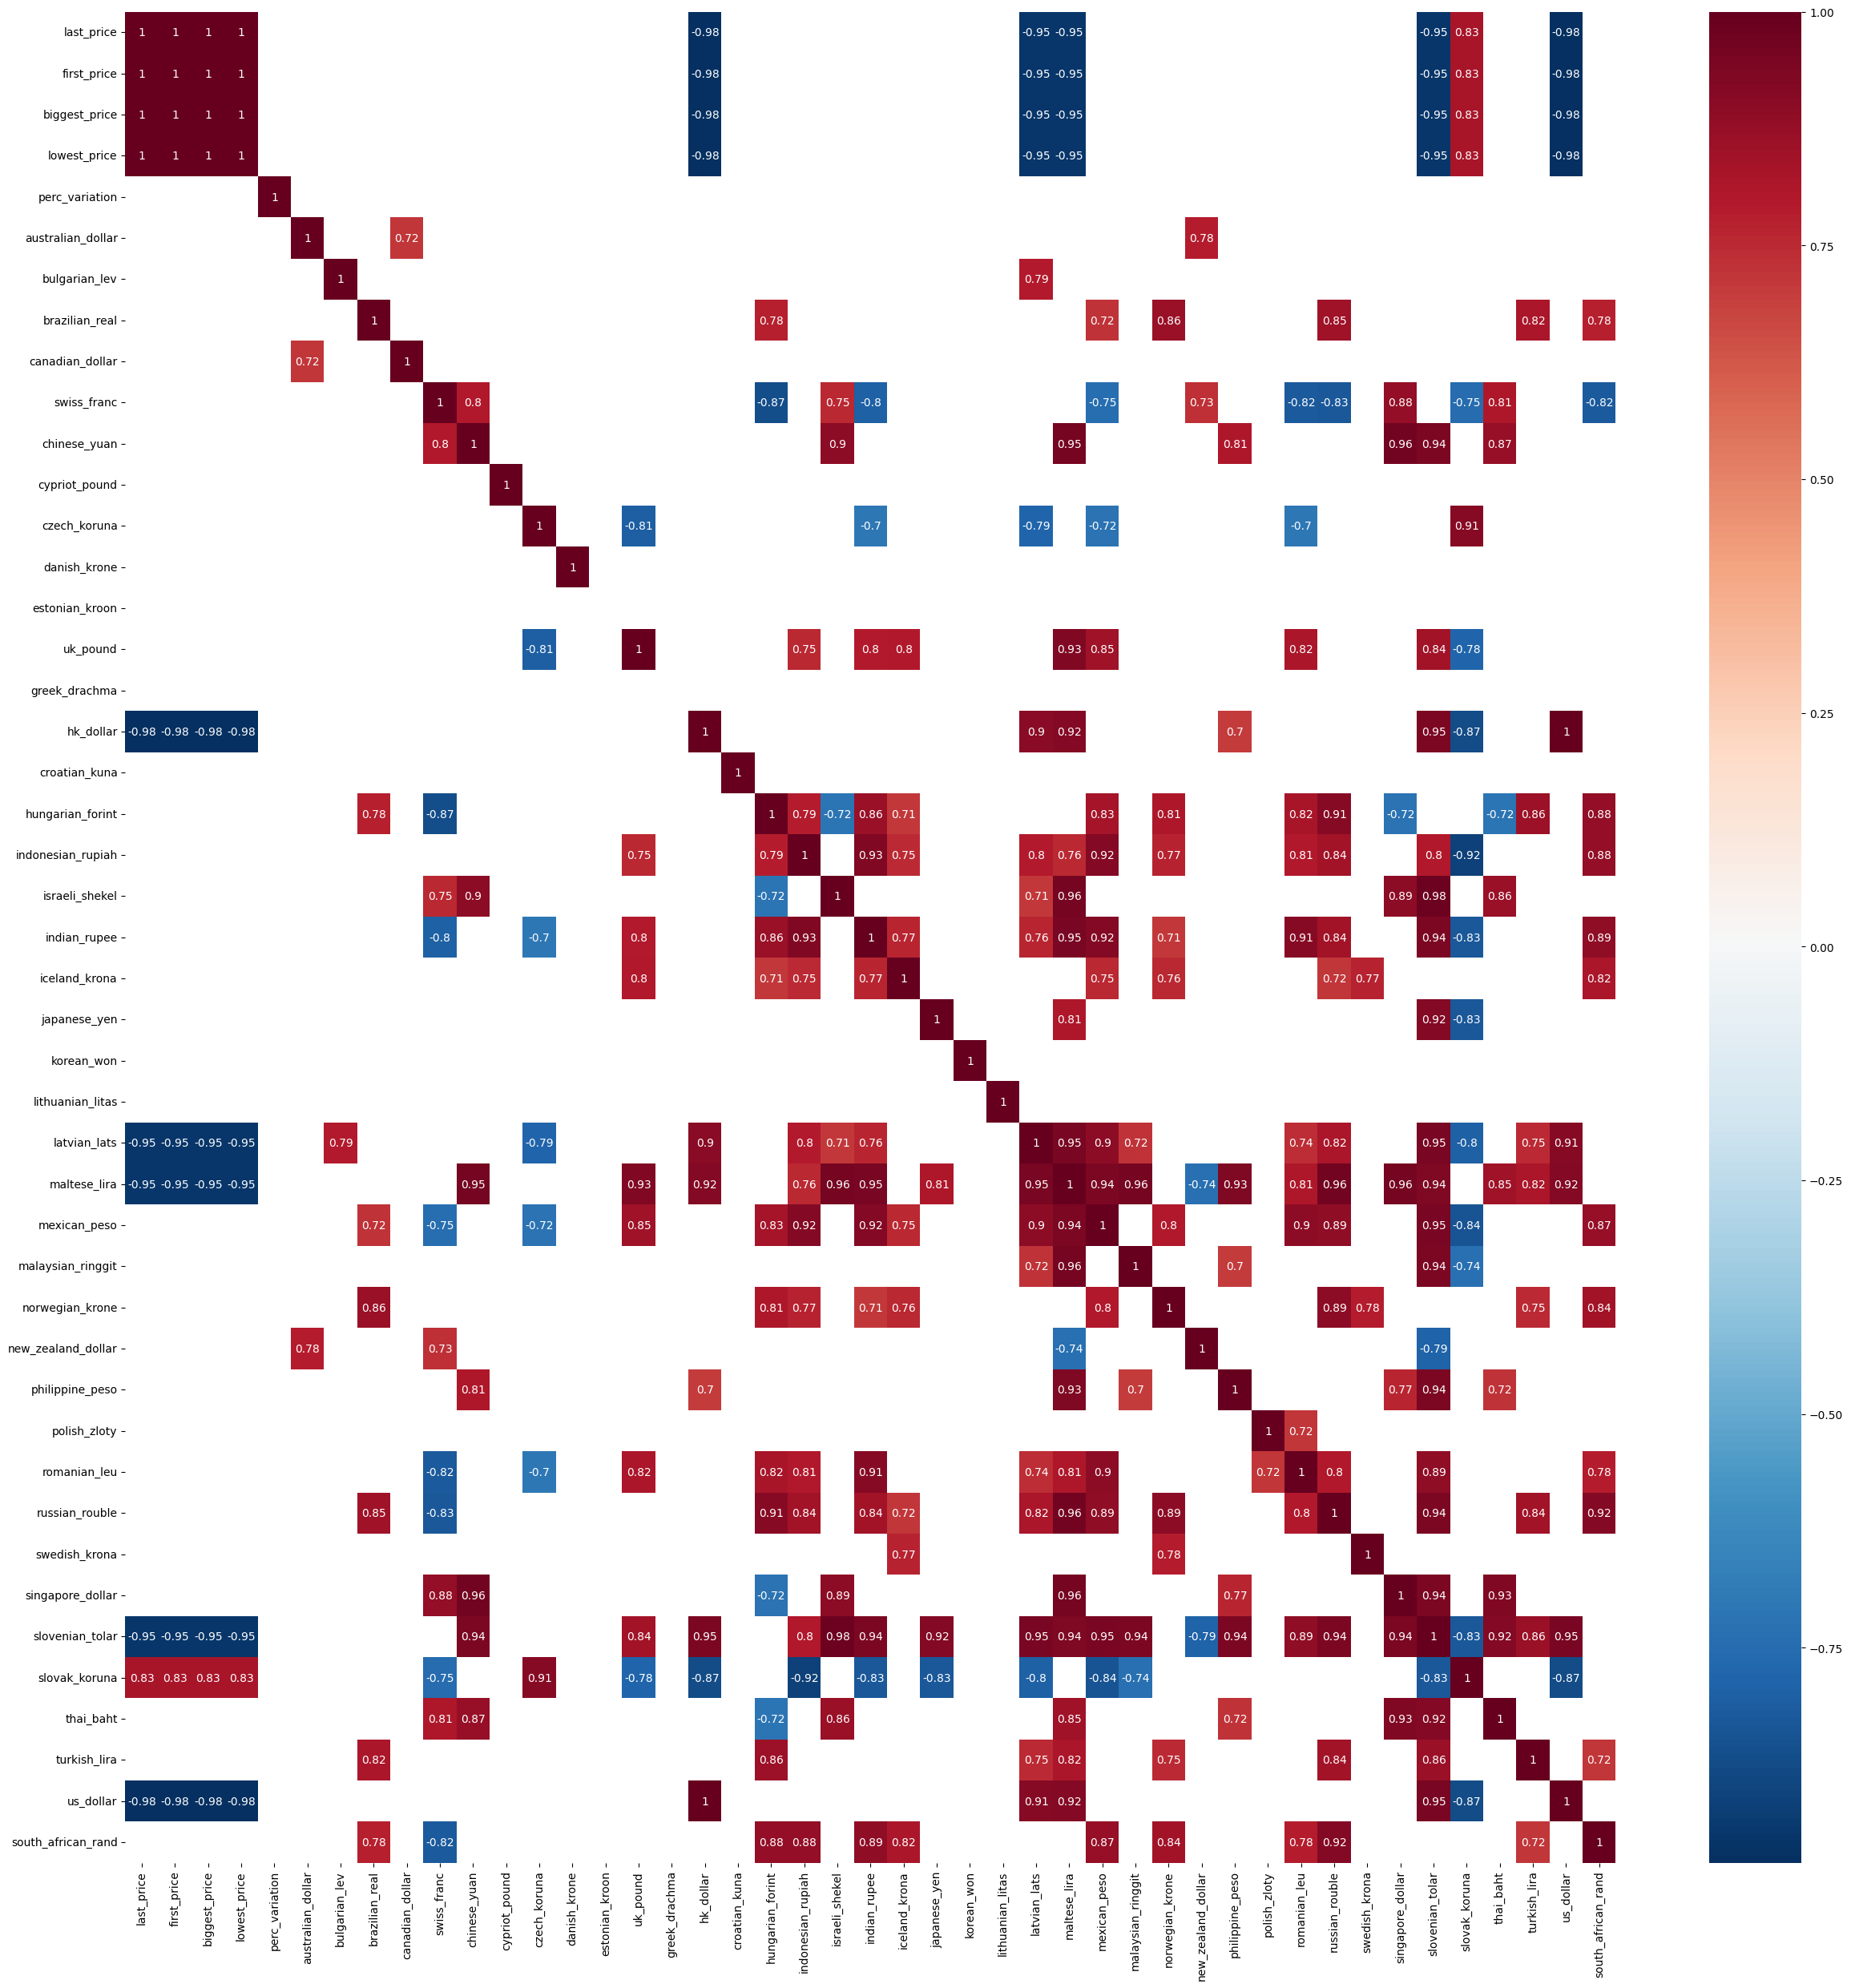

In [118]:
# Correlation matrix for strongly correlated positive or negative values
plt.figure(figsize=(30, 30))
correlation_matrix = df_enriched.iloc[:, :-1].corr()
mask = (correlation_matrix > 0.70) | (correlation_matrix < -0.70)
sns.heatmap(correlation_matrix[mask], annot=True, cmap='RdBu_r')
plt.show()

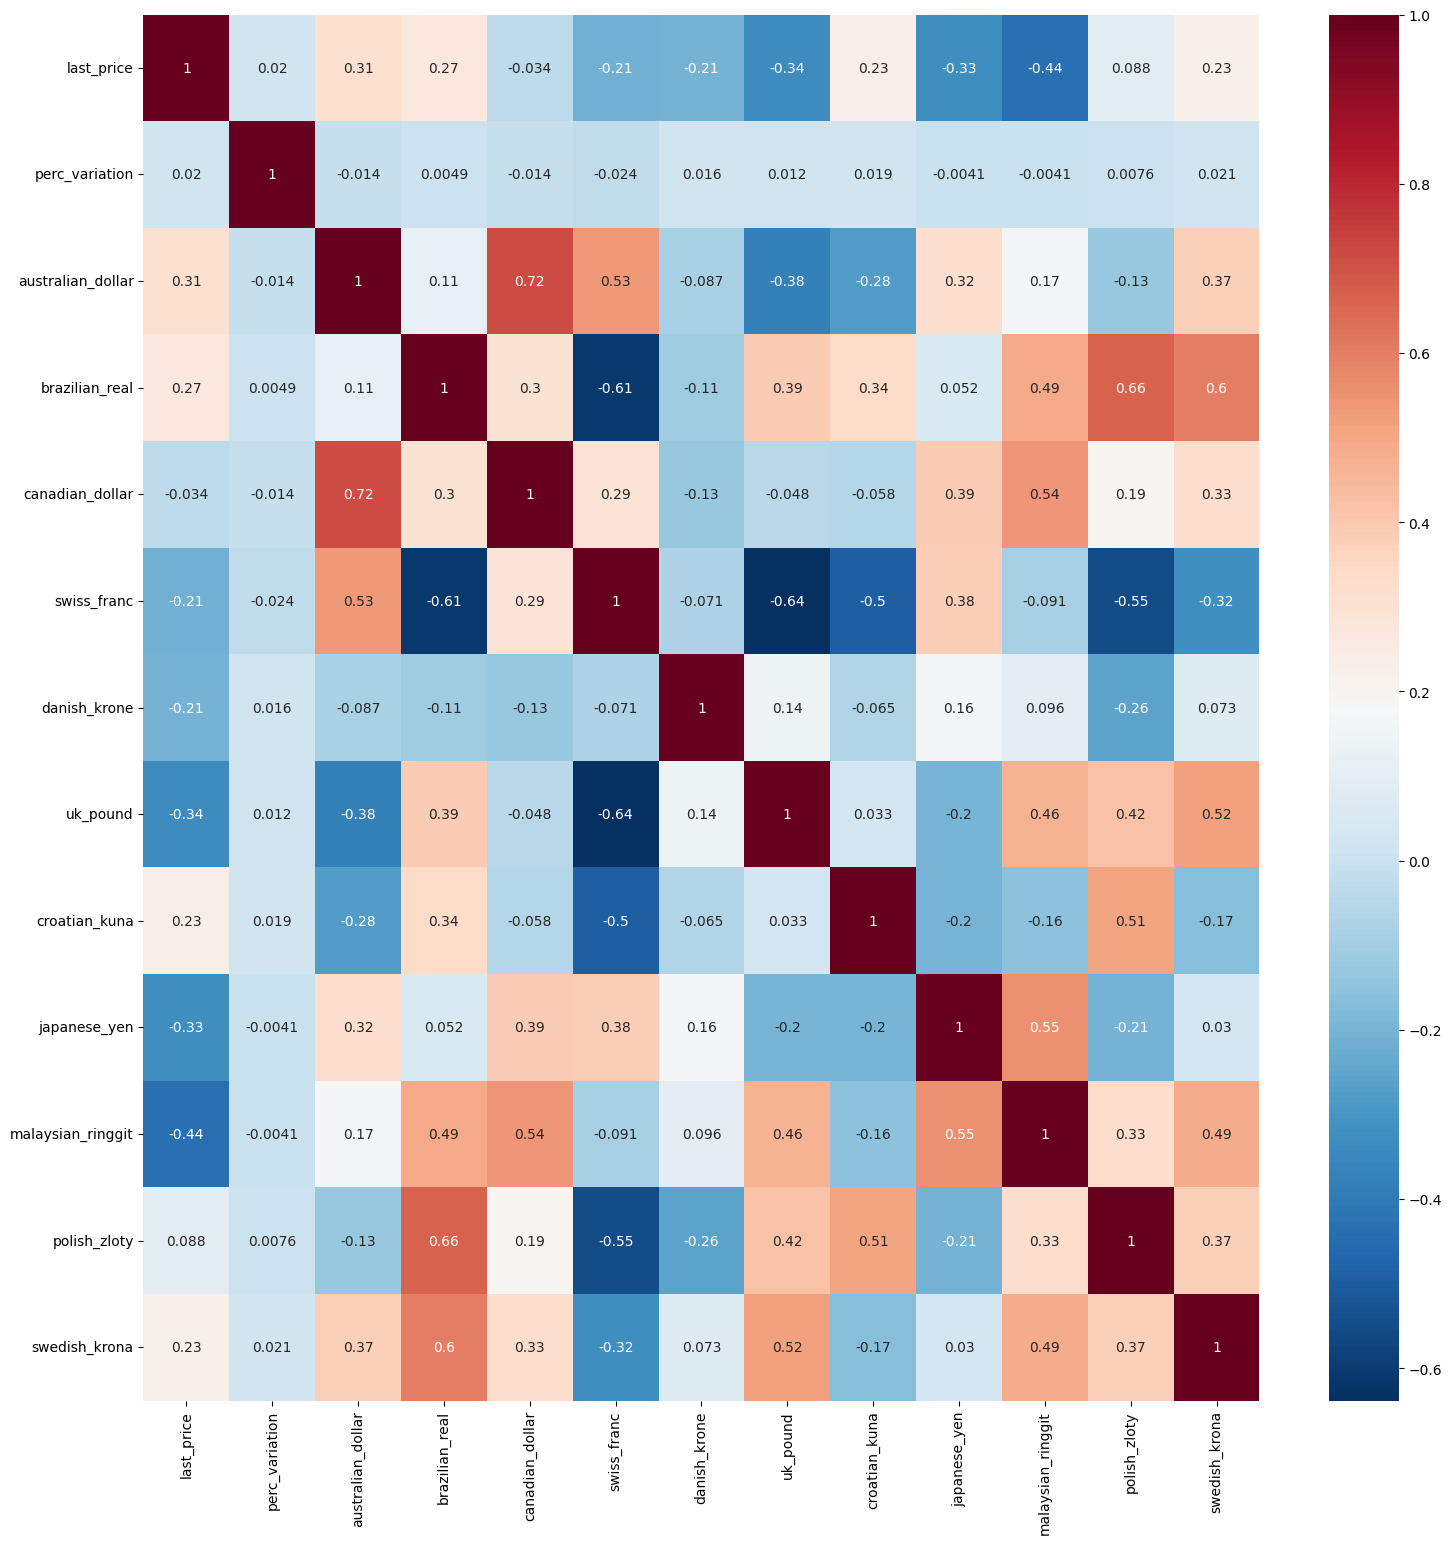

In [119]:
# List all correlacted features
lst_features = df_enriched.columns.to_list()
lst_correlated_features = ['first_price', 'biggest_price', 'lowest_price', 'slovenian_tolar', 'slovak_koruna', 'us_dollar', 'turkish_lira', 'south_african_rand', 'singapore_dollar', 'thai_baht', 'hungarian_forint']
lst_correlated_features += ['latvian_lats', 'mexican_peso', 'norwegian_krone', 'new_zealand_dollar', 'russian_rouble', 'hk_dollar', 'maltese_lira', 'czech_koruna', 'indonesian_rupiah', 'indian_rupee', 'iceland_krona', 'estonian_kroon', 'greek_drachma']
lst_correlated_features += ['chinese_yuan', 'romanian_leu', 'cypriot_pound', 'lithuanian_litas', 'bulgarian_lev', 'philippine_peso', 'israeli_shekel', 'korean_won']

# Removing correlated features
for col in lst_correlated_features:
  lst_features.remove(col)

# Show the correlation between the features sample
df_filtered = df_enriched.loc[:, lst_features]
plt.figure(figsize=(18, 18))
sns.heatmap(df_filtered.iloc[:, :-1].corr(), annot=True, cmap='RdBu_r')
plt.show()

Although the Canadian and Austrailia dollar have a correlation of just over 70%, we know from business knowledge that these currencies are important for the price of the US dollar, so we decided to keep them.

Total of rows 5569


<Axes: >

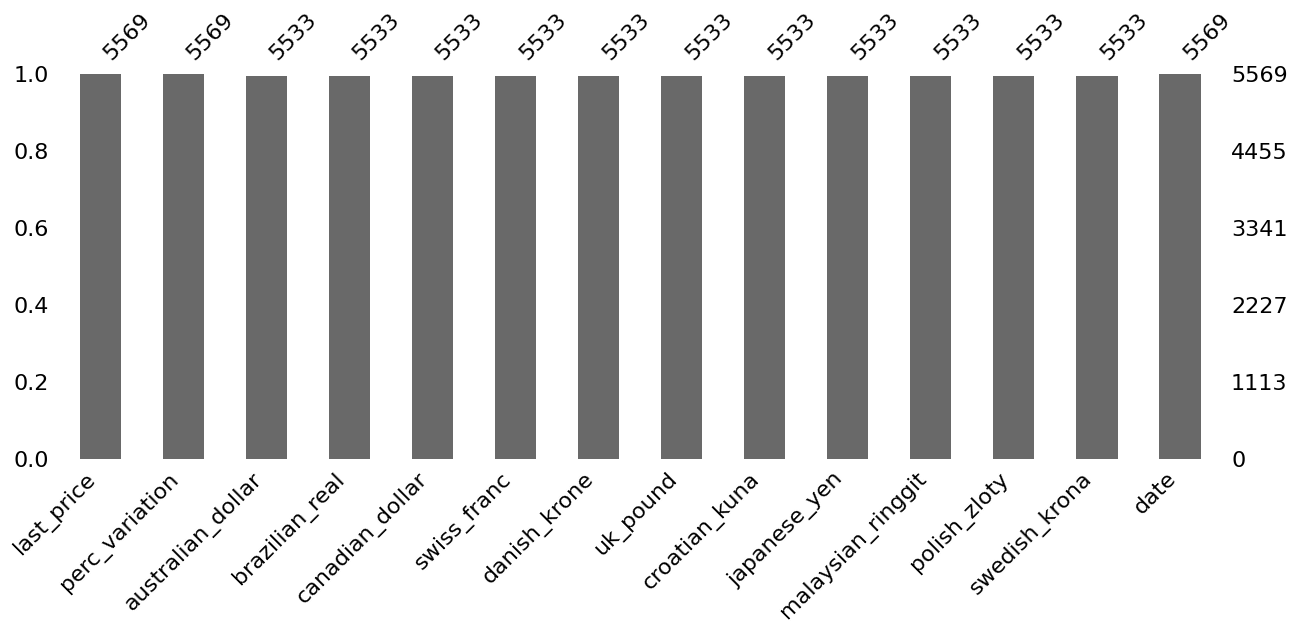

In [120]:
# Check how many Missing Values there are
print(f"Total of rows {df_filtered.shape[0]}")
ms.bar(df_filtered, figsize=(15,5))

In [121]:
# Checking the Descriptive Statistics of numerics columns
print(df_filtered.describe())

        last_price  perc_variation  australian_dollar  brazilian_real  \
count  5569.000000     5569.000000        5533.000000     5533.000000   
mean     90.478107        0.001219           1.572534        3.463612   
std      10.708799        0.485459           0.155623        1.172879   
min      71.330000       -3.020000           1.163900        1.799400   
25%      81.430000       -0.280000           1.465700        2.595800   
50%      89.940000        0.000000           1.594300        3.167900   
75%      96.930000        0.270000           1.673100        3.961500   
max     120.900000        2.560000           2.073500        6.955300   

       canadian_dollar  swiss_franc  danish_krone     uk_pound  croatian_kuna  \
count      5533.000000  5533.000000   5533.000000  5533.000000    5533.000000   
mean          1.465625     1.314896      7.448481     0.787610       7.458325   
std           0.095128     0.209298      0.011386     0.093446       0.124425   
min           1.21

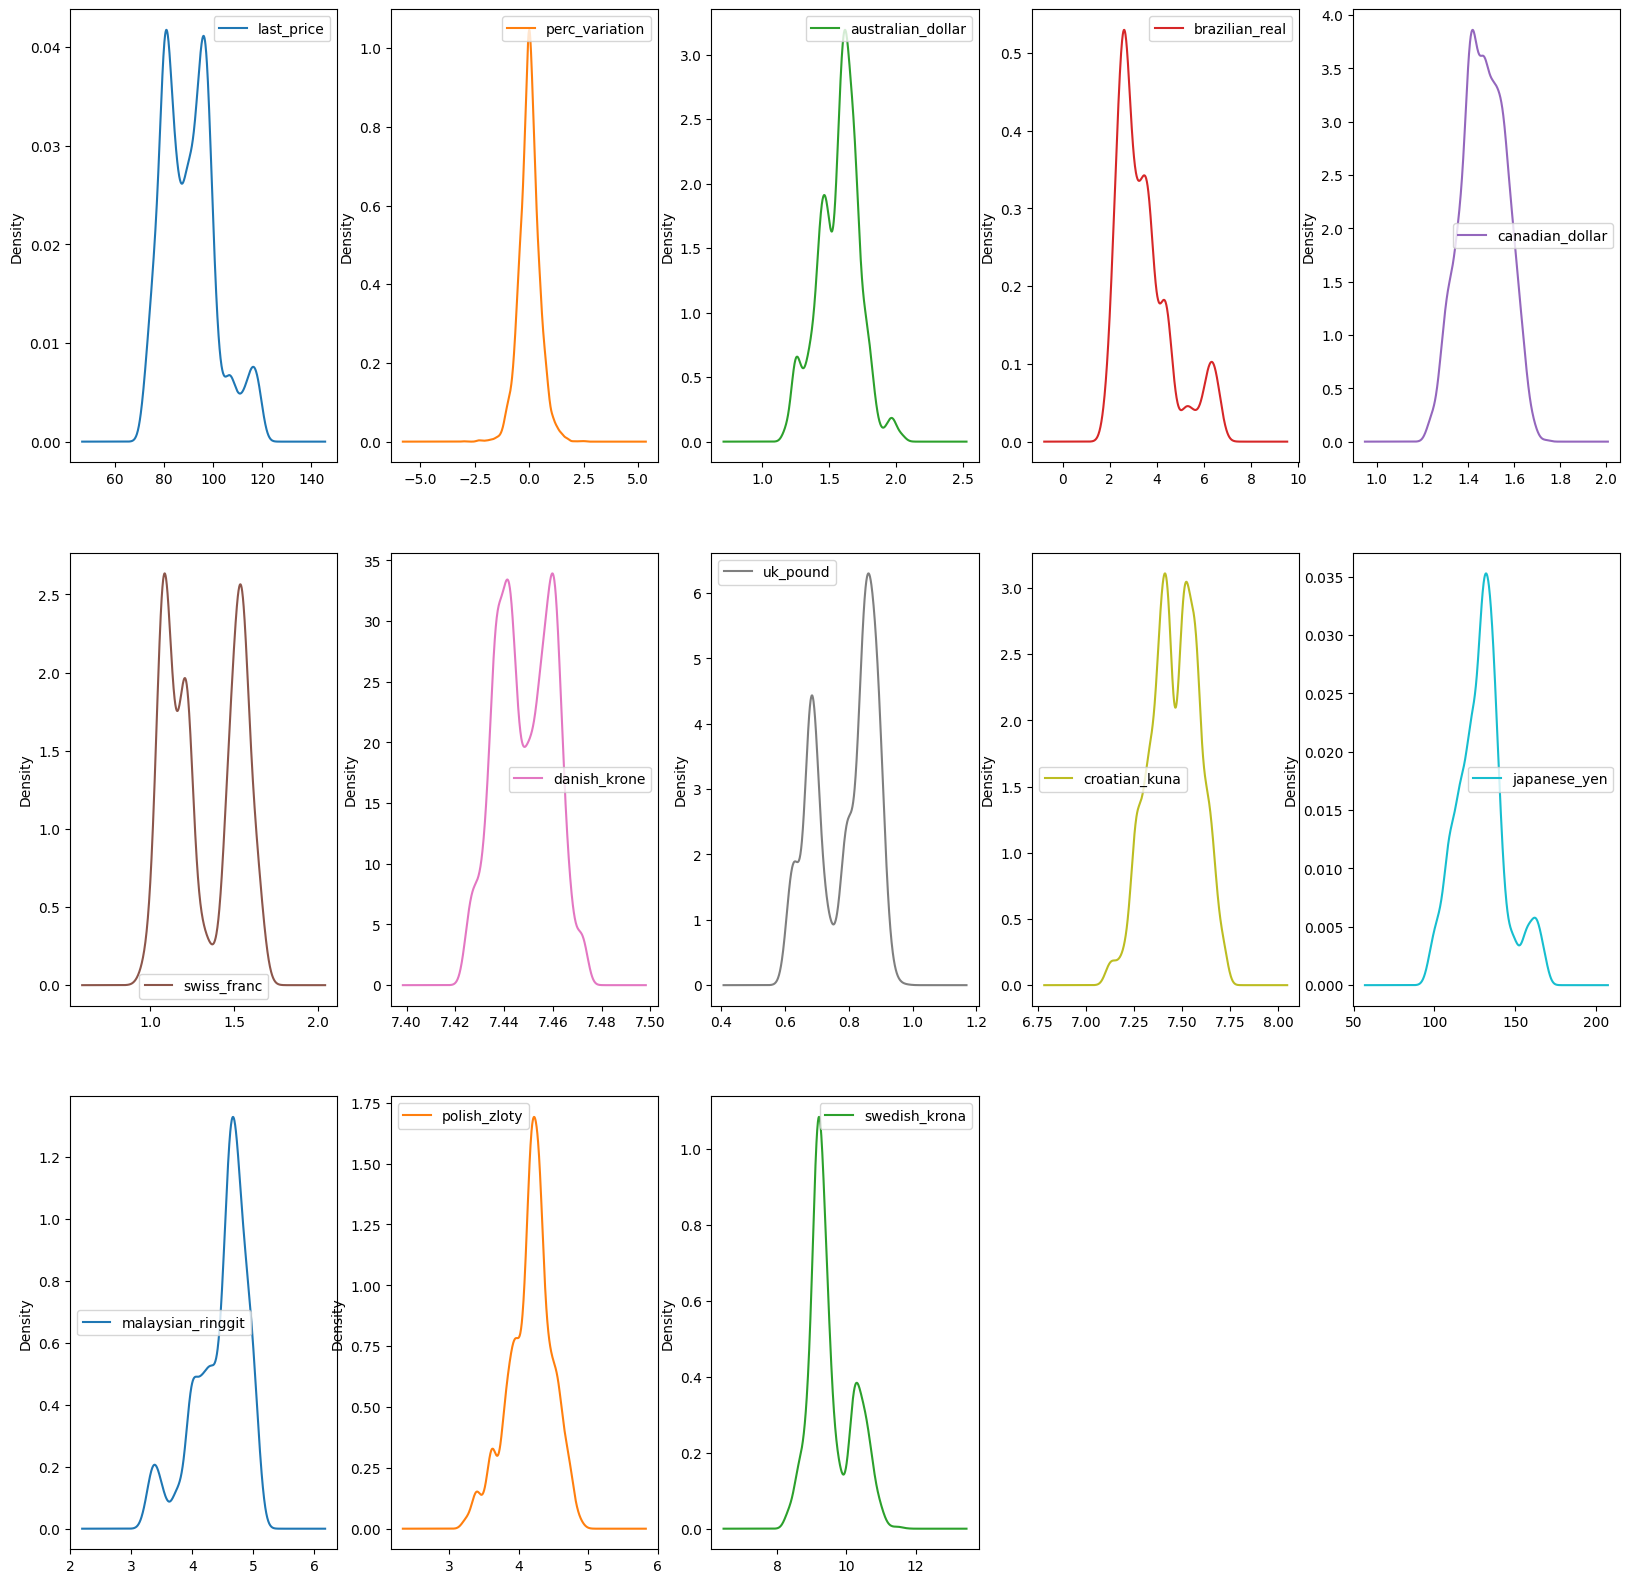

In [122]:
# Now let's check the density distribution of numeric columns
df_filtered.plot(kind = 'density', subplots = True, layout = (3,5), sharex = False, figsize = (20,20))
plt.show()


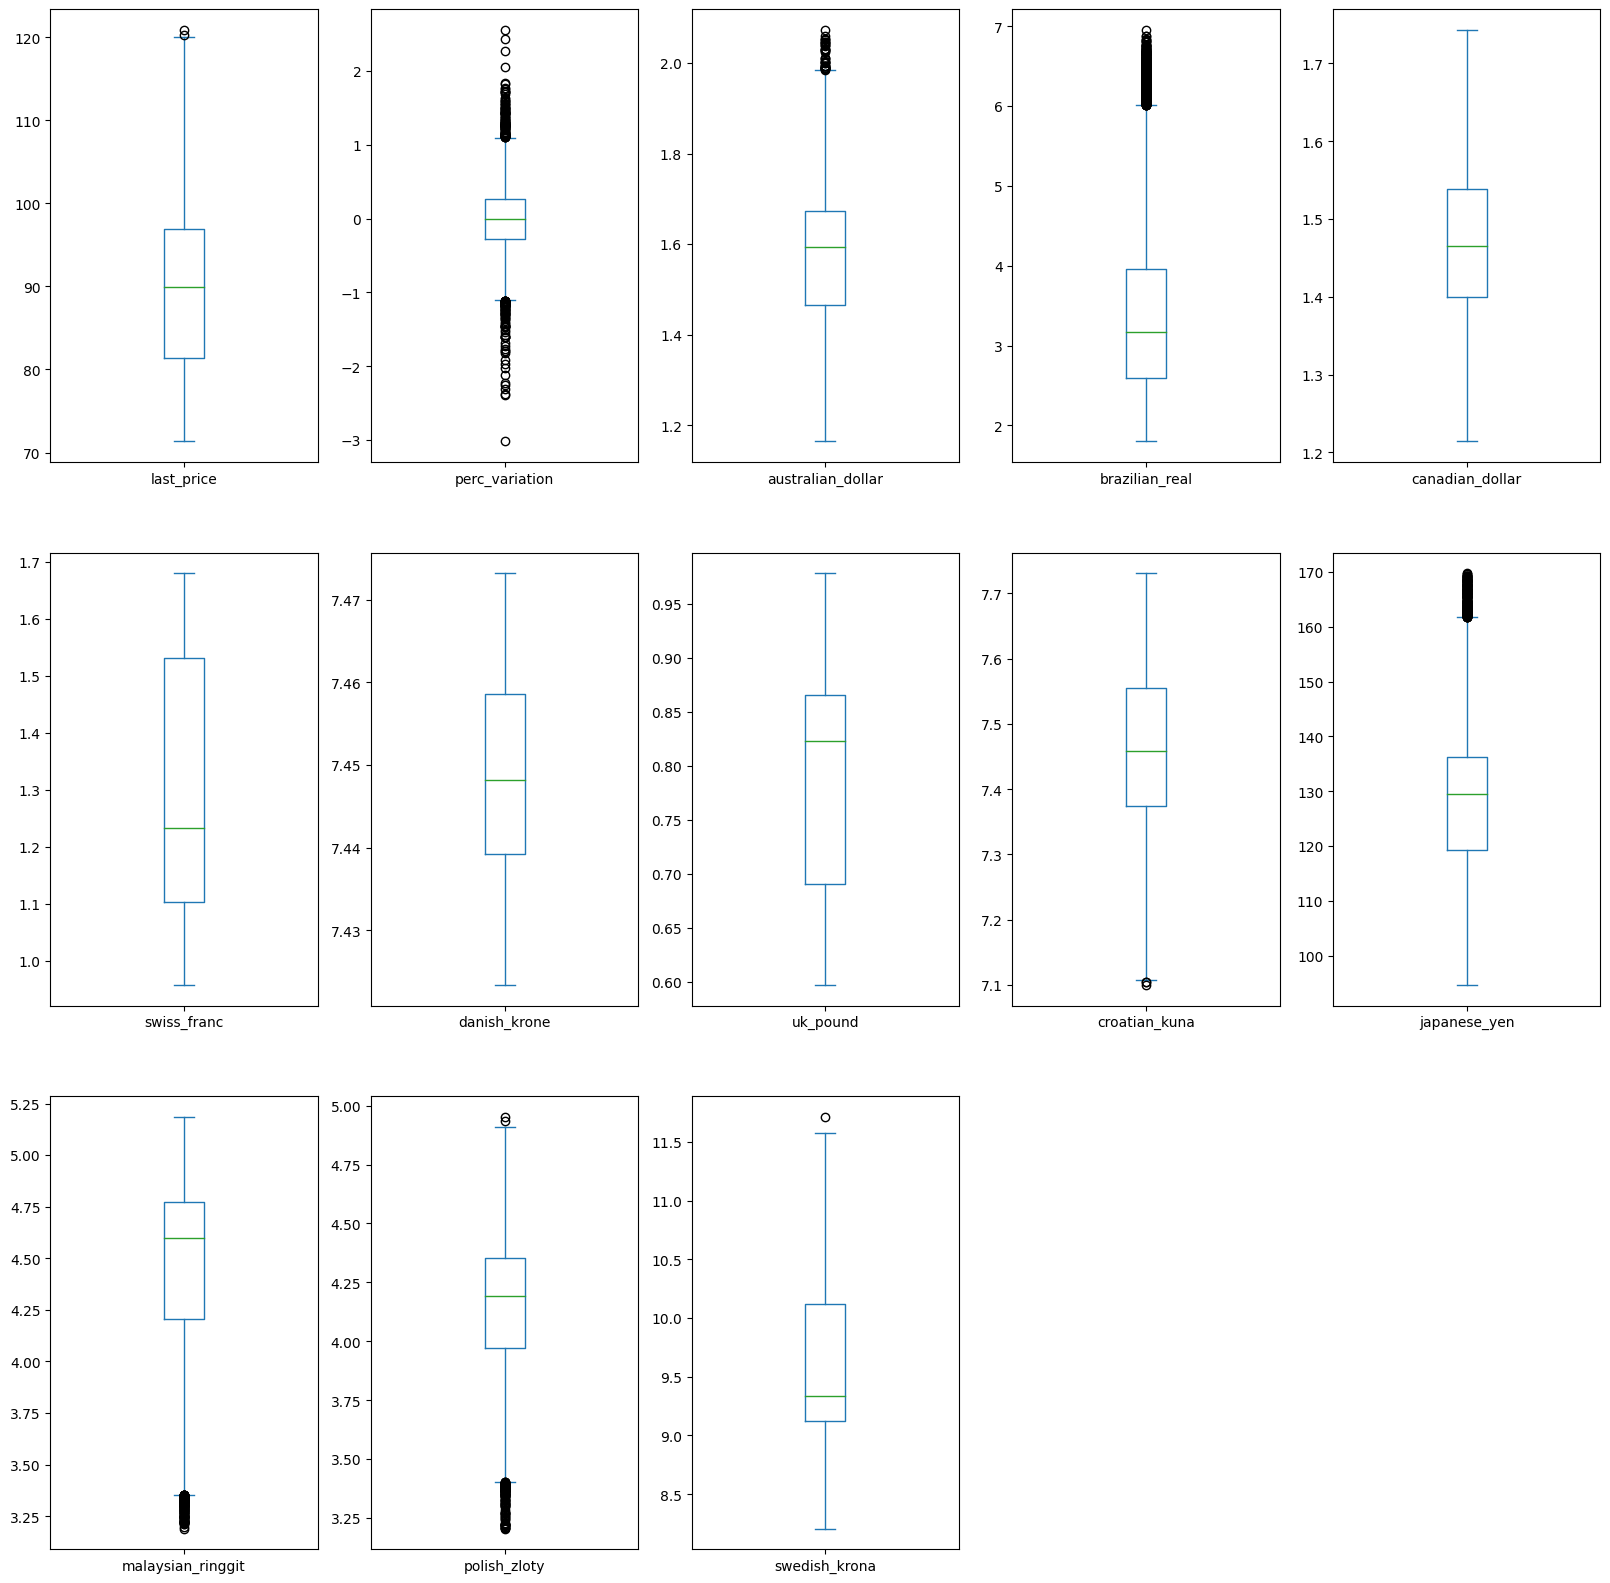

In [123]:
# Finally verifying if there is any outlier values based on IQR technique
df_filtered.plot(kind = 'box', subplots = True, layout = (3,5), sharex = False, sharey = False, figsize = (20,20))
plt.show()

## Data Cleansing up

This chapter is to preprocess the data before applying any machine learning algorithm. Therefore, we will detect outlier and null values to replace those for estimated value.

### Replace outliers

Outliers increase the noise in the data. It is a difficult task to find out what the correct value of the signal would be. Often, this task is impossible to discover.

The data has few outliers detected by the IQR method, maybe because both datasets came from Kaggle. Just to be sure, let's deal with these outliers values using:
 1. perc_variation: the values of all columns will be recalculated based on the documentation
 2. other columns: replace for NaN and on the next step it'll receive the average between the day before and the day after

We know that the currency market is volatile and perhaps the discrepant values identified in the perc_variation column are a reflection of the market. Just for verification purposes, we will recalculate all the values in this column according to the official documentation

In [124]:
df_cleaned = df_filtered.copy()
df_cleaned['calculated_perc_variation'] = 100 * ((df_cleaned['last_price'] / df_cleaned['last_price'].shift()) - 1)
df_cleaned.loc[0, 'calculated_perc_variation'] = df_cleaned.loc[0, 'perc_variation']
print(df_cleaned[['perc_variation', 'calculated_perc_variation']].describe())

       perc_variation  calculated_perc_variation
count     5569.000000                5569.000000
mean         0.001219                   0.001271
std          0.485459                   0.485685
min         -3.020000                  -3.018085
25%         -0.280000                  -0.275716
50%          0.000000                   0.000000
75%          0.270000                   0.273335
max          2.560000                   2.555828


In [125]:
# Just deciding on one of the two
df_cleaned['perc_variation'] = df_cleaned['calculated_perc_variation']
df_cleaned.drop(columns=['calculated_perc_variation'], axis=1, inplace=True)

Based on the descriptive statistics above, we can see that the change was not very significant. In general, the data has changed from the third decimal place. Since we've to decide on one of the two columns, we'll keep the value of calculated_perc_variation by replacing the values in perc_variation.

For currency there are some outliers, we'll replace the outlier values for NaN. On the next step (replace missing values), these NaN will be replaced.

In [126]:
list_indices = [0, 2, 3, 8, 9, 10, 11, 12]
print("Removing outlier values: ")
for i in list_indices:
    print(f"\tStarting with {df_cleaned.columns[i]}")
    # IQR Range mask
    q3 = df_cleaned.iloc[:, i].quantile(0.75)
    q1 = df_cleaned.iloc[:, i].quantile(0.25)
    iqr = q3 - q1
    iqr_sup_lim = df_cleaned.iloc[:, i] > (q3 + 1.5 * iqr) # value close to q3
    iqr_inf_lim = df_cleaned.iloc[:, i] < (q1 - 1.5 * iqr) # value close to q1

    # Main mask
    mask = iqr_sup_lim | iqr_inf_lim
    df_cleaned.iloc[mask, i] = np.nan # replace by Not a Number value

Removing outlier values: 
	Starting with last_price
	Starting with australian_dollar
	Starting with brazilian_real
	Starting with croatian_kuna
	Starting with japanese_yen
	Starting with malaysian_ringgit
	Starting with polish_zloty
	Starting with swedish_krona


### Replace Missing Values

There are only missing values in the currency columns. So we'll fill in these columns by calculating the average between the previous and next values of the missing value.

In [127]:
# Get columns name from dataframe
lst_index_column = [0] + list(range(2, 14))
for col in df_cleaned.iloc[:, lst_index_column].columns:
  mask = df_cleaned.loc[:, col].isna()
  print(f"Filling in {col} column")
  while mask.any():
    df_cleaned.loc[mask, col] = df_cleaned[col].shift()
    mask = df_cleaned.loc[:, col].isna()

Filling in last_price column
Filling in australian_dollar column
Filling in brazilian_real column
Filling in canadian_dollar column
Filling in swiss_franc column
Filling in danish_krone column
Filling in uk_pound column
Filling in croatian_kuna column
Filling in japanese_yen column
Filling in malaysian_ringgit column
Filling in polish_zloty column
Filling in swedish_krona column
Filling in date column


### Double-checking on cleaned dataframe
Finally let's check if all missing values and outliers were removed.

<Axes: >

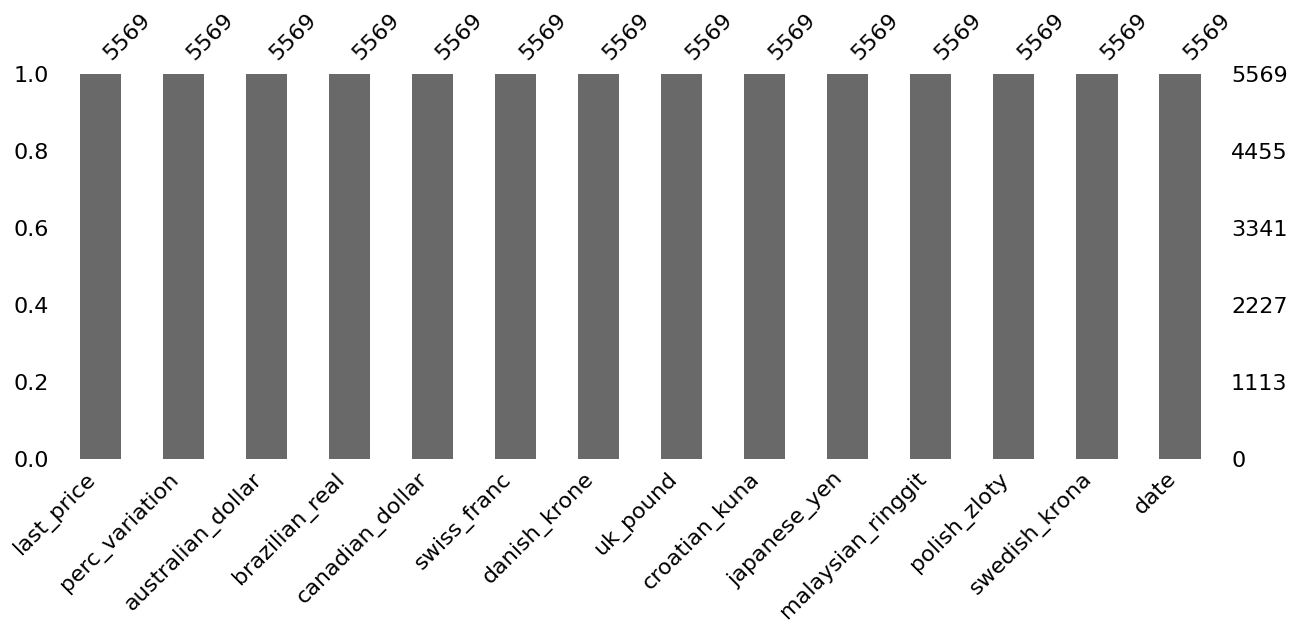

In [128]:
ms.bar(df_cleaned, figsize=(15,5))

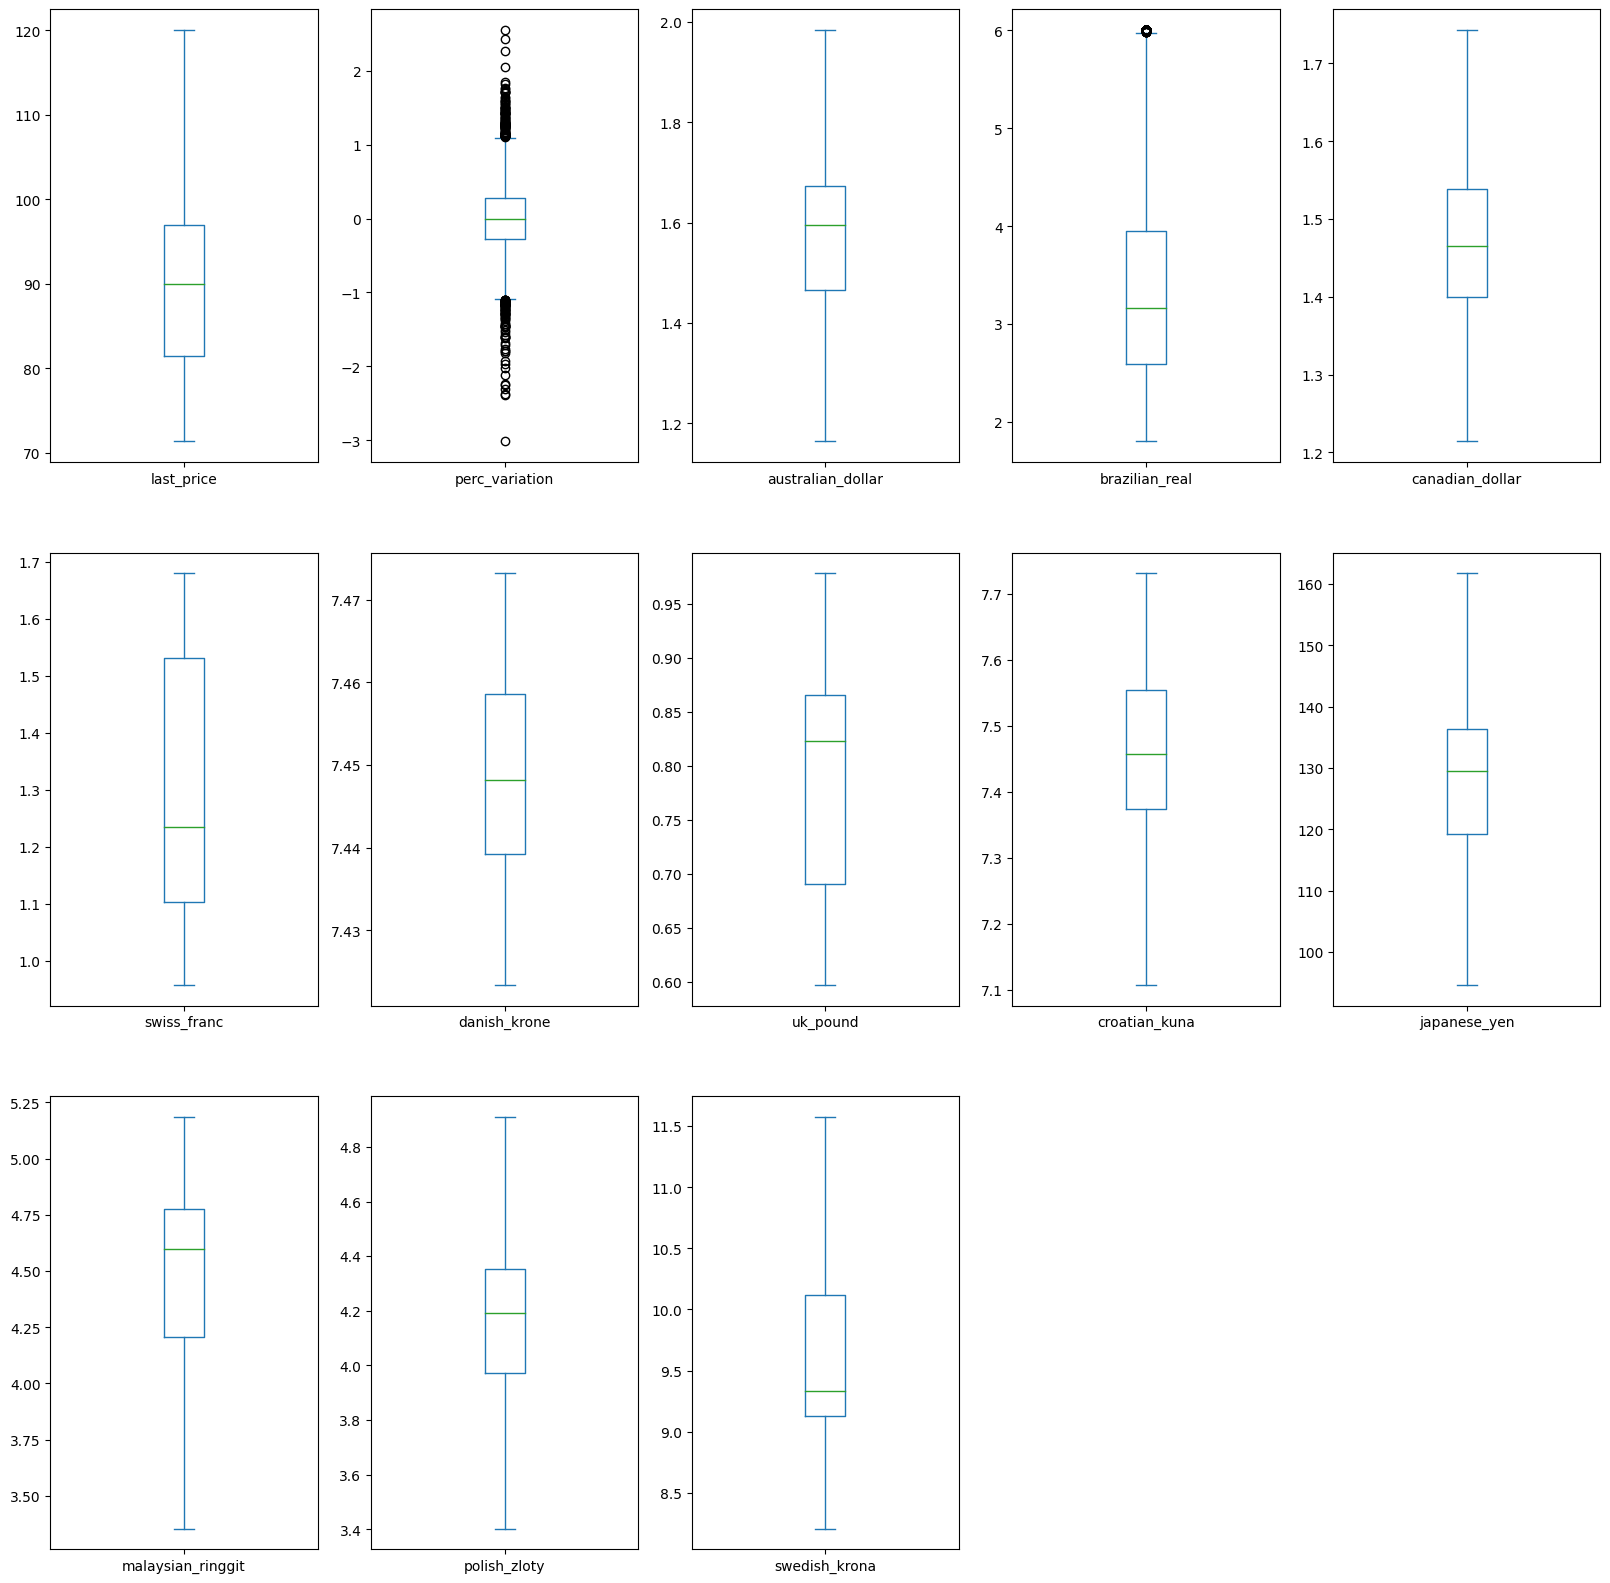

In [129]:
# Finally verifying if there is any outlier values based on IQR technique
df_cleaned.plot(kind = 'box', subplots = True, layout = (3,5), sharex = False, sharey = False, figsize = (20,20))
plt.show()

## Feature Engineering

From this point, we'll create additional features to increase the prediction. As this problem is time series one, the sequency is relevante and then we'll create column for year, month, day and day of week.

Also we'll create a moving-average column over 28 days and catch the previous last price in 7 days.

At last we'll add a new one columns: perc_future_variation. This one will be used to define the categories of this problem (target-column)

In [130]:
# Ordering the data
df_cleaned.sort_values(by=['date'], ascending=True)

# Create 3 new features
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
df_cleaned['day'] = df_cleaned['date'].dt.day
df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['year'] = df_cleaned['date'].dt.year
df_cleaned['day_of_week'] = df_cleaned['date'].dt.weekday
df_cleaned.drop(columns=['date'], axis=1, inplace=True)

# Moving-average of last 28 days and last price of previous 7 days
df_cleaned['mov_avg_28_last_price'] = df_cleaned['last_price'].rolling(window=28, min_periods=28).mean()
df_cleaned['last_price_prev_7_days'] = df_cleaned['last_price'].shift(7)

# Perc. Future Variation]
df_cleaned['perc_future_variation'] = 100 * ((df_cleaned['last_price'].shift(-1) / df_cleaned['last_price']) - 1)

# Remove rows that are Missing Values from moving average, previous 7 days and perc future variation
df_cleaned = df_cleaned.dropna()

In [131]:
# Show the output
print(df_cleaned.head(5).to_markdown())

|    |   last_price |   perc_variation |   australian_dollar |   brazilian_real |   canadian_dollar |   swiss_franc |   danish_krone |   uk_pound |   croatian_kuna |   japanese_yen |   malaysian_ringgit |   polish_zloty |   swedish_krona |   day |   month |   year |   day_of_week |   mov_avg_28_last_price |   last_price_prev_7_days |   perc_future_variation |
|---:|-------------:|-----------------:|--------------------:|-----------------:|------------------:|--------------:|---------------:|-----------:|----------------:|---------------:|--------------------:|---------------:|----------------:|------:|--------:|-------:|--------------:|------------------------:|-------------------------:|------------------------:|
| 27 |       112.06 |        1.0551    |              1.698  |           1.8403 |            1.3916 |        1.5312 |         7.4613 |     0.6355 |          7.7105 |         106.97 |              3.504  |         3.7696 |          8.8795 |     8 |       2 |   2001 |          

## Predict target column by KNN and logistic regression

At this point, we only have a clean dataframe from kaggle and did some feature engineering. Now we'll decide for 3 categories that explain the percentage of future variation. To find out the threshould, we'll plot a histogram chart over that column.

### Define target column

<Axes: >

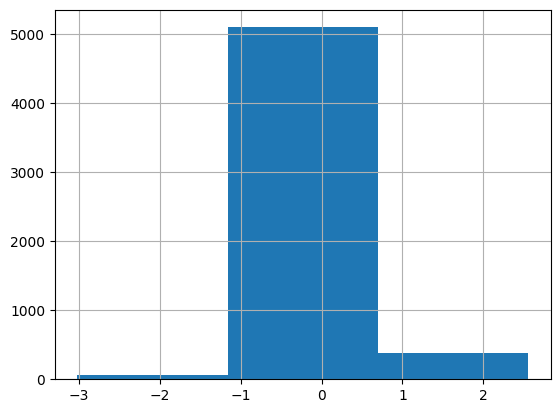

In [132]:
# Find out the classes of problems
df_cleaned.perc_future_variation.hist(bins=3)

Based on histogram, the 3 categories are:


*   A: Less Equal to -1
*   B: Greater than -1 and less than 1
*   C: Greater equal to 1





In [133]:
# Creating the conditions for each category and then apply it for the column value
choices = ['A', 'B', 'C']
conditions = [
    df_cleaned['perc_future_variation'].le(-1),
    (df_cleaned['perc_future_variation'].gt(-1)) & (df_cleaned['perc_future_variation'].lt(1)),
    (df_cleaned['perc_future_variation'].ge(1)),
]

df_cleaned['category'] = np.select(conditions, choices, default=np.nan)

# Once the category column was created, the perc_future_variation must be deleted
df_cleaned.drop(columns=['perc_future_variation'], axis=1, inplace=True)

### Feature Normalization

To increase the algorithms peformance, we'll normalize all features column using MinMaxScaler. The output will be values in the range 0 and 1.

In [134]:
df_normalized = df_cleaned.copy()

scaler = MinMaxScaler()
# Avoiding target column
for i in range(0,df_normalized.shape[1] - 1):
  df_normalized.iloc[:, i] = scaler.fit_transform(df_normalized.iloc[:, [i]])

At this point, we expect that there are only uncorrelated variables (> 0.7 or < -0.7) to feed machine learning algoritms. The unique exceptions are moving average and last price of previous 7 days, both were calculated based on last_price.

We decided to keep those because this problem is based on time series and then it's relevante to add some chronological data to the present datapoint.

### Forecast Prediction with KNN and Logaritmic Regression

Now it's time to check the prediction from two differents machine learning algorithms: KNN and Logaritmic Regression. First of all, we split the dataset between train and test, using the stratified method.

In [135]:
# Stratified Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(df_normalized.iloc[:, :-1], df_normalized.iloc[:, -1], test_size=0.2, random_state=7, stratify=df_cleaned.iloc[:, -1])

# Now getting a validation dataframe from X_test and y_test: testing (60%) and Validation (40%)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.4, random_state=7, stratify=y_test)

categories = df_cleaned.iloc[:, -1].unique()
n_categories = len(categories[0])

#### KNN

In [136]:
# Create a Logistic Regression model
model = KNeighborsClassifier(n_neighbors=n_categories)

# Define the hyperparameter grid
param_grid = {
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'metric': 'manhattan', 'weights': 'uniform'}
Best Cross-Validation Score: 0.9117773406185661


In [137]:
# KNN
knn = KNeighborsClassifier(n_neighbors=n_categories, weights = best_params['weights'], metric = best_params['metric'])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Show the overall report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        16
           B       0.95      0.96      0.95       632
           C       0.06      0.06      0.06        17

    accuracy                           0.91       665
   macro avg       0.34      0.34      0.34       665
weighted avg       0.90      0.91      0.91       665



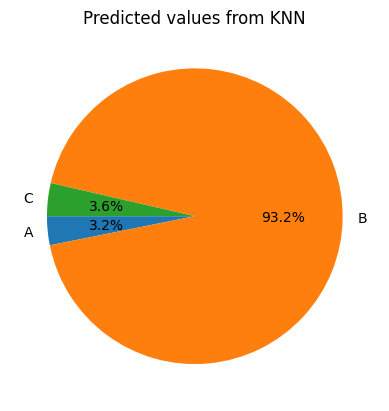

In [138]:
# Now it's time to predict the unknown values from cleaned dataset
y_pred = knn.predict(X_validation)

unique, counts = np.unique(y_pred, return_counts=True)
plt.title("Predicted values from KNN")
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=180)
plt.show()

Accuracy on Test Set: 0.8963963963963963



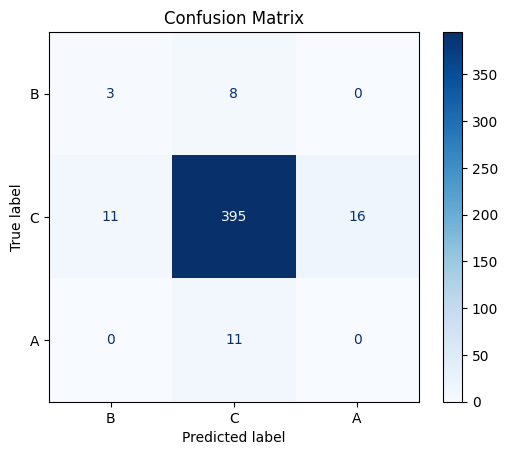

In [139]:
# Compute confusion matrix
cm = confusion_matrix(y_validation, y_pred)

# Calculate accuracy
print(f"Accuracy on Test Set: {accuracy_score(y_validation, y_pred)}\n")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#### Logistic Regression

We'll find out the best hyperparameters for that problem and then apply those to classify the categories.

In [140]:
# Create a Logistic Regression model
model = LogisticRegression()

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Optimization algorithms
    'penalty': ['l2', 'l1','none'],  # Regularization type
    'max_iter': [50,100,200,250] # Maximum Iteration
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'C': 0.01, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Cross-Validation Score: 0.9505867293054173


In [141]:
# Create a Logistic Regression model
model = LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'], penalty=best_params['penalty'], solver=best_params['solver'])

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Show the overall report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        16
           B       0.95      1.00      0.97       632
           C       0.00      0.00      0.00        17

    accuracy                           0.95       665
   macro avg       0.32      0.33      0.32       665
weighted avg       0.90      0.95      0.93       665



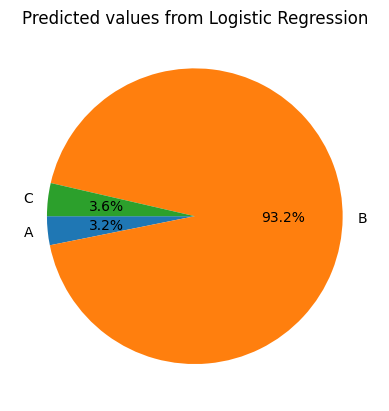

In [142]:
# Now it's time to predict the unknown values from cleaned dataset
y_pred = knn.predict(X_validation)
unique, counts = np.unique(y_pred, return_counts=True)
plt.title("Predicted values from Logistic Regression")
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=180)
plt.show()

Accuracy on Test Set: 0.8963963963963963



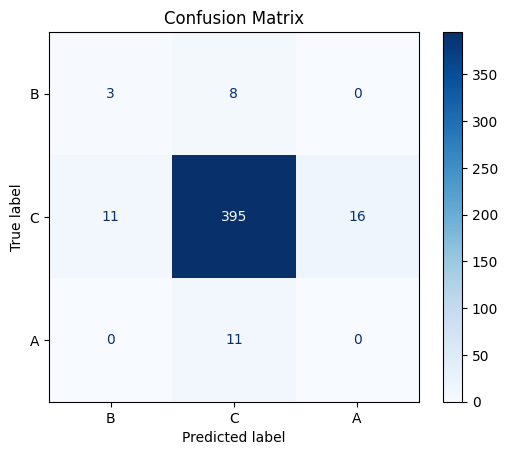

In [143]:
# Compute confusion matrix
cm = confusion_matrix(y_validation, y_pred)

# Calculate accuracy
print(f"Accuracy on Test Set: {accuracy_score(y_validation, y_pred)}\n")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Both models obtained the same accuracy for the validation data set, although they had different accuracy scores during the testing phase.

Finally, as we have shown, using machine learning to create a prediction of the dollar's price category can be useful, but using historical points alone is not enough. For this reason, analysts often consider NLP algorithms for news analysis.